In [220]:
import dianna
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [221]:
transform = transforms.Compose([torchvision.transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [222]:
model_path = "./models/mnist_model.onnx" # an onnx model containing a cNN for the binary-mnist, aka. classifying as 0 or 1
axis_labels = {0: 'channels'}

In [223]:
return_training_tensors_from_target_class = lambda target: trainset.data[trainset.targets == target]

In [224]:
first_zero = return_training_tensors_from_target_class(0)[0]

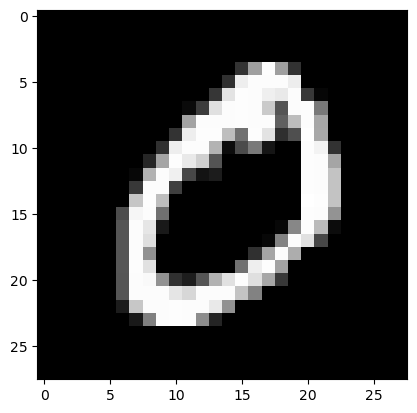

In [225]:
# Display the first zero as reference
plt.imshow(first_zero, cmap="grey")

Explaining: 100%|██████████| 1000000/1000000 [2:00:46<00:00, 138.00it/s]  


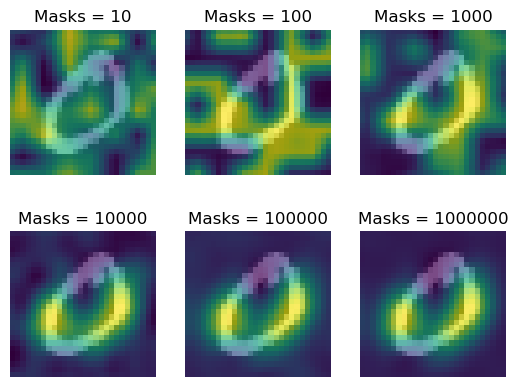

In [226]:
# Generate a grid-picture with the first zero, showing saliency maps generated with RISE but with a different number of masks
fig, ax = plt.subplots(2, 3)
num_of_masks=[[10**1, 10**2, 10**3], [10**4, 10**5, 10**6]]
first_zero_input = first_zero.numpy().reshape(1, 28, 28).astype(np.float32)
for i in range(2):
    current_masks = num_of_masks[0] if i == 0 else num_of_masks[1]
    for j in range(3):
        saliency_map_rise = dianna.explain_image(model_path, first_zero_input, method="RISE", labels=[0], n_masks=current_masks[j], axis_labels=axis_labels, p_keep=0.5)
        ax[i, j].set_title(f"Masks = {current_masks[j]}")
        ax[i, j].imshow(saliency_map_rise.reshape(28, 28))
        ax[i, j].imshow(first_zero.reshape(28, 28), cmap="grey", alpha=.3)
        ax[i, j].set_axis_off()
plt.savefig("images/intended_for_paper/rise_n_masks.png")

In [227]:
def save_heatmaps_side_by_side_with_original_as_png_file(index_as_filename:int, original_zero, rise_map, lime_map, shap_map):
    original_zero = original_zero.reshape(28, 28) # Reshape to original image format for display
    rise_map = rise_map.reshape(28, 28)
    lime_map = lime_map.reshape(28, 28)
    shap_map = shap_map.reshape(28, 28)
    fig, ax = plt.subplots(1, 4, figsize=(7, 2))
    ax[0].set_title("Original Data")
    ax[0].imshow(original_zero, cmap="grey")
    ax[0].set_axis_off()
    ax[1].set_title("RISE")
    ax[1].imshow(rise_map)
    ax[1].imshow(original_zero, alpha=.3)
    ax[1].set_axis_off()
    ax[2].set_title("LIME")
    ax[2].imshow(lime_map)
    ax[2].imshow(original_zero, alpha=.3)
    ax[2].set_axis_off()
    ax[3].set_title("KernelSHAP")
    ax[3].imshow(shap_map)
    ax[3].imshow(original_zero, alpha=.3)
    ax[3].set_axis_off()
    plt.savefig(f"images/saliency_maps/{index_as_filename + 1}_zero.png")

In [228]:
normalize_input_img = lambda img: (img / 255).astype(np.float32)

def run_all_explainibility_methods_on_first_k_inputs_and_return_mean_saliency_map(k_first_samples: int):
    for i in range(k_first_samples):
            zero = return_training_tensors_from_target_class(0)[i]
            zero = zero.numpy().reshape(1, 28, 28).astype(np.float32) # Reshape to right format expected for the input
            
            # RISE
            saliency_map_rise = dianna.explain_image(model_path, zero, method="RISE", labels=[0], n_masks=10**4, axis_labels=axis_labels, p_keep=0.5)
            # LIME
            saliency_map_lime = dianna.explain_image(model_path, zero, method="LIME", labels=[0], axis_labels=axis_labels, num_features=100, num_samples=10000, preprocess_function=normalize_input_img)[0]
            # SHAP
            saliency_map_shap = dianna.explain_image(model_path, zero, method="KernelSHAP", axis_labels=axis_labels, labels=[0], background=0, nsamples=10000, n_segments=200)[0]
        
            save_heatmaps_side_by_side_with_original_as_png_file(i, zero, saliency_map_rise, saliency_map_lime, saliency_map_shap)

In [229]:
%%capture
run_all_explainibility_methods_on_first_k_inputs_and_return_mean_saliency_map(1) # Just for showcase, for the 100 images, the parameter was a 100 of course

2024-06-23 19:37:54.960445: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard/branch_executed/_9
2024-06-23 19:37:55.079120: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard/branch_executed/_9
2024-06-23 19:37:57.922963: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard/branch_executed/_9
